<a href="https://colab.research.google.com/github/hasballa/A-Visual-History-of-Nobel-Prize-Winners/blob/master/covid_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [4]:
fid = drive.ListFile({'q':"title='archive.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('archive.zip')


In [5]:
import zipfile
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
import os
base_dir = '/content/Covid19-dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

# Directory with our validation cat/dog pictures
validation_covid_dir = os.path.join(validation_dir, 'Covid')
validation_normal_dir = os.path.join(validation_dir, 'Normal')
validation_pneumonia_dir = os.path.join(validation_dir, 'Viral Pneumonia')

In [7]:
train_covid_fnames = os.listdir(train_covid_dir)
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

print(train_covid_fnames[:10])
print(train_normal_fnames[:10])
print(train_pneumonia_fnames[:10])

['COVID-00034.jpg', 'COVID-00029.jpg', '088.jpeg', 'COVID-00002.jpg', 'COVID-00030.jpg', '065.jpeg', '074.jpg', 'COVID-00024.jpg', 'COVID-00018.jpg', '012.jpeg']
['088.jpeg', '092.jpeg', '065.jpeg', '097.jpeg', '012.jpeg', '071.jpeg', '015.jpeg', '059.jpeg', '021.jpeg', '069.jpeg']
['065.jpeg', '012.jpeg', '045.jpeg', '071.jpeg', '021.jpeg', '078.jpeg', '095.jpeg', '094.jpeg', '06.jpeg', '010.jpeg']


In [8]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration

nrows = 6
ncols = 4

pic_index = 0 # Index for iterating over images

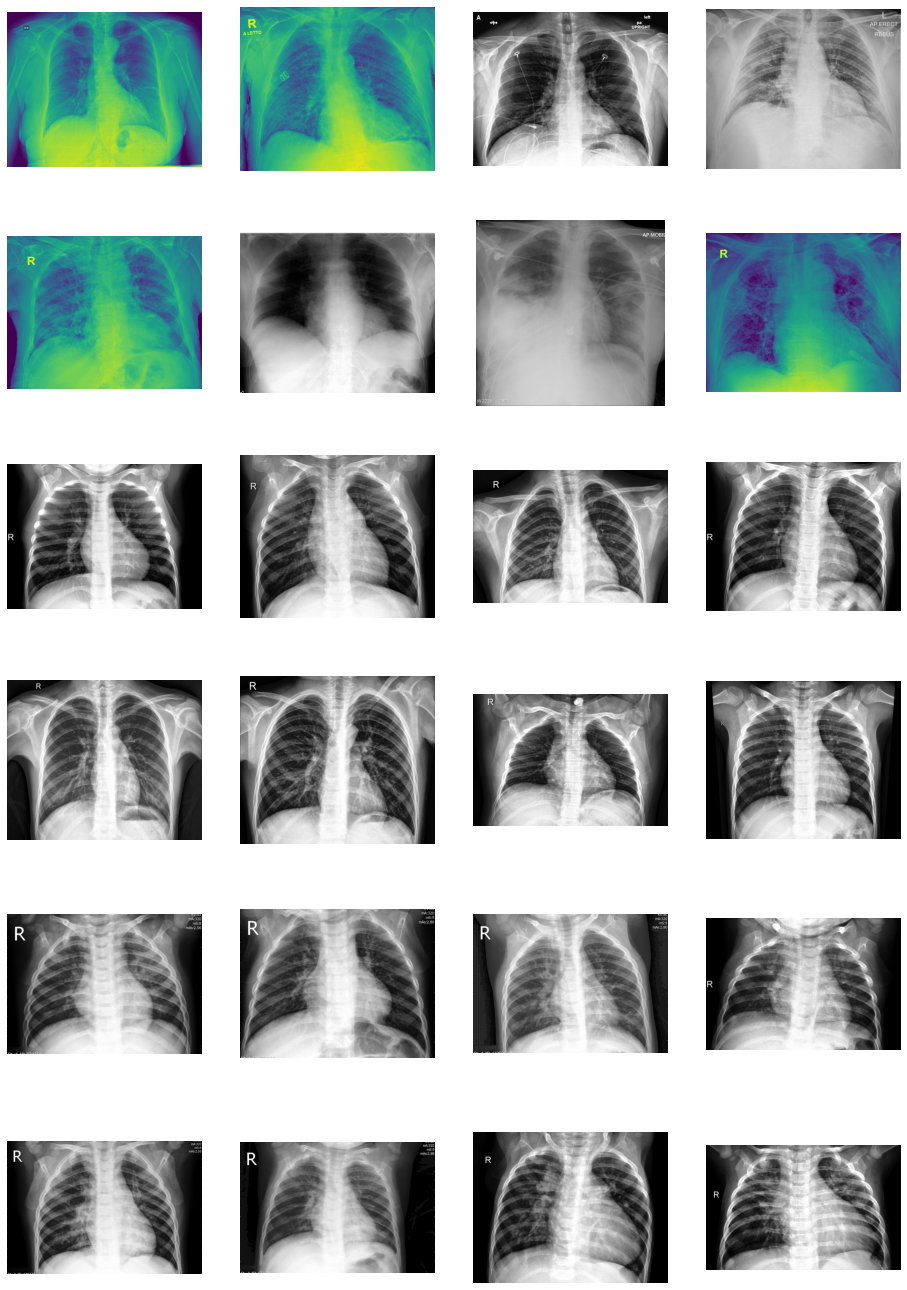

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_covid_pix = [os.path.join(train_covid_dir, fname) 
                for fname in train_covid_fnames[ pic_index-8:pic_index] 
               ]

next_normal_pix = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) 
                for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_covid_pix+next_normal_pix+next_pneumonia_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## the next step is to define the model that will be trained to recognize covid, normal or Viral Pneumonia from these images

In [10]:
import tensorflow as tf
 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [12]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [15]:
history = model.fit(train_generator,
                              steps_per_epoch=10,
                              epochs=15,
                              verbose=2)

Epoch 1/15
10/10 - 7s - loss: 0.0189 - accuracy: 0.9950
Epoch 2/15
10/10 - 7s - loss: 0.0104 - accuracy: 0.9948
Epoch 3/15
10/10 - 7s - loss: 0.0059 - accuracy: 1.0000
Epoch 4/15
10/10 - 7s - loss: 0.0018 - accuracy: 1.0000
Epoch 5/15
10/10 - 7s - loss: 0.0012 - accuracy: 1.0000
Epoch 6/15
10/10 - 7s - loss: 7.1579e-04 - accuracy: 1.0000
Epoch 7/15
10/10 - 7s - loss: 4.4903e-04 - accuracy: 1.0000
Epoch 8/15
10/10 - 7s - loss: 6.7154e-04 - accuracy: 1.0000
Epoch 9/15
10/10 - 7s - loss: 4.3386e-04 - accuracy: 1.0000
Epoch 10/15
10/10 - 7s - loss: 4.0210e-04 - accuracy: 1.0000
Epoch 11/15
10/10 - 7s - loss: 3.3149e-04 - accuracy: 1.0000
Epoch 12/15
10/10 - 7s - loss: 3.3632e-04 - accuracy: 1.0000
Epoch 13/15
10/10 - 7s - loss: 3.2474e-04 - accuracy: 1.0000
Epoch 14/15
10/10 - 7s - loss: 2.9664e-04 - accuracy: 1.0000
Epoch 15/15
10/10 - 7s - loss: 1.8525e-04 - accuracy: 1.0000


#Running the Model
Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object has covid, normal or Viral Pneumonia.

[0. 0. 1.] --> Viral Pneumonia,
[1. 0. 0.] --> Covid, 
[0. 1. 0.] --> Normal

In [17]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])

Saving 01.jpeg to 01.jpeg
[0. 1. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


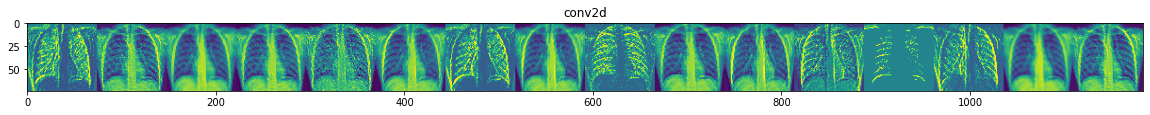

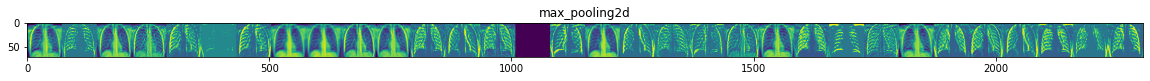

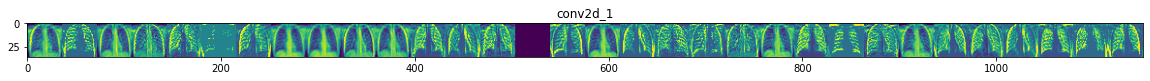

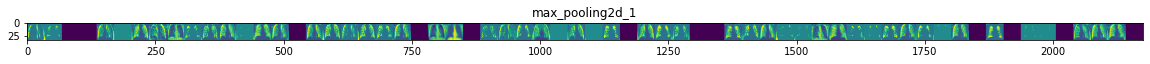

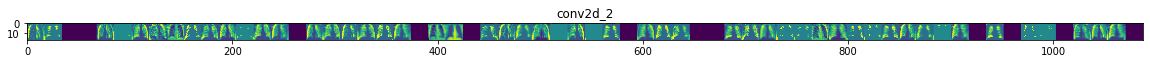

In [18]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
covid_img_files = [os.path.join(train_covid_dir, f) for f in train_covid_fnames]
normal_img_files = [os.path.join(train_normal_dir, f) for f in train_normal_fnames]
pneumonia_img_files = [os.path.join(train_pneumonia_dir, f) for f in train_pneumonia_fnames]

img_path = random.choice(covid_img_files + normal_img_files + pneumonia_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 